# Classiq Challenge: Simulating classical oscillators


In [33]:
import numpy as np
from numpy import kron, linalg as LA
from math import log2
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from typing import cast
from classiq import (
    Output,
    QBit,
    allocate,
    create_model,
    synthesize,
    show,
    set_preferences,
    CustomHardwareSettings,
    Preferences,
    QuantumProgram,
    QArray,
    execute,
    prepare_state,
    exponentiation_with_depth_constraint,
    qfunc,
    write_qmod,
    authenticate,
    Pauli,
    PauliTerm
)


In [34]:
# authenticate(overwrite=True)

In [35]:
def parse_results(results,basis_states, N):
    """
    This function takes a result from the Classiq simulator and parse it into a pandas dataframe
    """
    res = results[0].dict()
    
    x = list(res['value']['counts'].keys())
    y = list(res['value']['counts'].values())
    
    data = pd.DataFrame([x,y]).T
    data.rename({0: 'state', 1: 'count'}, axis=1, inplace=True)
    data['count'] = data['count'].astype(int)

    data.sort_values(by='state', inplace=True)

    data['prob'] = data['count'] / data['count'].sum()

    
    measured_states = set(data['state'])


    if len(basis_states) != len(measured_states):
        
        not_measured = basis_states.difference(measured_states)

        zeros = {'state': [i for i in not_measured], 'count': [0] * len(not_measured), 'prob': [0] * len(not_measured)}
        
        df_zeros = pd.DataFrame(zeros)
        data = pd.concat([data, df_zeros]).sort_values('state')

    data.set_index('state', inplace=True)

    return data

# generate all combinations of Pauli strings of size n
def generate_all_pauli_strings(seq, n):
    for s in product(seq, repeat=n):
        yield "".join(s)


Paulidict = {
    "I": np.array([[1, 0], [0, 1]], dtype=np.complex128),
    "Z": np.array([[1, 0], [0, -1]], dtype=np.complex128),
    "X": np.array([[0, 1], [1, 0]], dtype=np.complex128),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}

# convert a Paulistring of size n to 2**n X 2**n matrix
def pauli_string_2mat(seq):
    myPmat = Paulidict[seq[0]]
    for p in seq[1:]:
        myPmat = kron(myPmat, Paulidict[p])
    return myPmat


# Hilbert-Schmidt-Product of two matrices M1, M2
def hilbert_schmidt(M1, M2):
    return (np.dot(M1.conjugate().transpose(), M2)).trace()


# Naive decomposition, running over all HS products for all Pauli strings
def lcu_naive(H):
    assert H.shape[0] == H.shape[1], "matrix is not square"
    assert H.shape[0] != 0, "matrix is of size 0"
    assert H.shape[0] & (H.shape[0] - 1) == 0, "matrix size is not 2**n"

    n = int(np.log2(H.shape[0]))
    myPualiList = list(generate_all_pauli_strings("IZXY", n))

    mylist = []

    for pstr in myPualiList:
        co = (1 / 2**n) * hilbert_schmidt(pauli_string_2mat(pstr), H)
        if co != 0:
            mylist = mylist + [(pstr, co)]

    return mylist



my_list = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}
def pauli_str_to_enums(pauli):
    return [my_list[s] for s in pauli]


def pauli_operator_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

# creats the basis for a given no of Qbit
def basis(N):
    tmp = [bin(i)[2:] for i in range(2**N)]

    longest = len(tmp[-1])

    return [ i if len(i) == longest else (longest - len(i)) * '0' + i for i in tmp]


# Filter functions to help

def kinectic_part(array):
    lenght = len(array)
    return array[:lenght//2]

def potential_part(array):
    lenght = len(array)
    return array[lenght//2:]

def average(arr, l, k,norm):
    """
    Calculate the average energy between the nth oscilator and the mth oscilator
    """
    E = (norm ** 2) / 2
    return E * np.sum(arr[l : l + k]) / (2 * k) 

#KE and PE for a given state
def KE_PE(state,E_0):
    KE_t = E_0*sum(kinectic_part(state))
    PE_t= E_0*sum(potential_part(state))
    return(KE_t,PE_t)

#check if varibles differ by a given percentage tolerance
def is_within_percent_tolerance(x,y,tolerance):
    if (np.abs(x-y)/y)*10 < tolerance :
        return(True)
    else:
        return(False)
    
def is_Energy_constant(KE,PE,E_0):
    if np.abs(KE+PE-E_0) < 10**(-4):
        return(True)
    else:
        return(False)

In [36]:
#K_matrix of system of identical spring constants in 1-d
def get_k_1D_identical(N,k):
    main_diagonal_values = np.full(N, k)  
    off_diagonal_values = np.full(N-1, k)      
    k_array = np.diag(main_diagonal_values) + np.diag(off_diagonal_values, k=1)+np.diag(off_diagonal_values, k=-1)
    return(k_array)   

#create mass matrix with mass of particles as diagonal entries for a system with identical masses 
def get_mass_identical(N,m):
    mass_array= np.full(N, m)
    mass = np.diag(mass_array)
    return(mass)

#Form Force in matrix form
def get_Force(k_array):
    N=k_array.shape[0]
    F = np.zeros((N,N))
    for i in range (0,N):
        for j in range (0,N):
            if(i==j):
                coff=0
                for k in range(0,N):
                    coff = coff + k_array[j][k]
                F[i][j]=coff
            else:
                F[i][j]=-k_array[i][j]
    return(F)

def get_H_B(F,M):
    mass_inverse = np.linalg.inv(M)
    mass_inverse = np.sqrt(mass_inverse)
    
    A=np.dot(np.dot(mass_inverse,F),mass_inverse)

    #finding B matrix
    B = np.linalg.cholesky(A)

    H = -1* np.block([
        [np.zeros(B.shape), B],
        [B.T, np.zeros(B.shape) ]
    ])
    return(H,B)

def get_normalized_psi(B,M,x_zero,x_dot_zero):
    y_zero = np.sqrt(M) @ x_zero
    y_dot_zero = np.sqrt(M) @ x_dot_zero
    mu_zero = B.T.conj() @ y_zero
    psi = np.concatenate([y_dot_zero, 1j * mu_zero])
    norm = np.sqrt((psi.conj() @ psi).real)
    psi /= norm     #normalization
    prob = list(np.abs(psi) ** 2)
    return(psi,prob,norm)


In [37]:
def energy_evoultion(max_depth,t_f,num_points,n,k,m,basis_states,x_zero,x_dot_zero):
    N=2**n
    K = get_k_1D_identical(N,k)
    M = get_mass_identical(N,m)
    F=get_Force(K)
    (H,B) = get_H_B(F,M)
    (psi,prob,norm)=get_normalized_psi(B,M,x_zero,x_dot_zero)
    E_0 = (norm**2)/2.0

    H_pauli = lcu_naive(H)
    H_final = pauli_operator_to_hamiltonian(H_pauli)

    total_kinetic = []
    total_potential = []
    KE_0=[]
    KE_1=[]
    KE_2=[]
    KE_3=[]
        
    PE_0=[]
    PE_1=[]
    PE_2=[]
    PE_3=[]

    time_steps = np.linspace(0, t_f, num = num_points)
    for t in time_steps:

        results = exponentiation(prob,max_depth,H_final,t)

        data = parse_results(results,basis_states, N)

        probs = data['prob']

        KE_0.append(E_0*probs[0])
        KE_1.append(E_0*probs[1])
        KE_2.append(E_0*probs[2])
        KE_3.append(E_0*probs[3])

        PE_0.append(probs[4])
        PE_1.append(probs[5])
        PE_2.append(probs[6])
        PE_3.append(probs[7])
        



        kin = kinectic_part(probs).sum() * E_0
        pontential = potential_part(probs).sum() * E_0

        total_kinetic.append(kin)
        total_potential.append(pontential)
    
    #plotting
    plt.plot(time_steps, total_kinetic, label='kinetic')
    plt.plot(time_steps, total_potential, label='potential')  

    return(total_kinetic, total_potential,E_0,KE_0,KE_1,KE_2,KE_3,PE_0,PE_1,PE_2,PE_3)    

In [38]:
### Does the state evolution ###
def exponentiation(prob,max_depth,H_final,t, write_qmodel_file=False, write_qprog_file=False,custom_run_time =False,show_qrog = False):
    @qfunc
    def main() -> None:
        state = QArray("state")
        prepare_state(probabilities=prob, bound=0.01, out=state)
        exponentiation_with_depth_constraint(
        H_final,
        evolution_coefficient=t,
        max_depth=max_depth,
        qbv=state,
        )
    model = create_model(main)

    if custom_run_time :

        custom_hardware_settings = CustomHardwareSettings(
        basis_gates=["cx", "cp", "sx", "rz", "x"]
        )

        preferences = Preferences(
        output_format=["qasm", "qsharp"],
        custom_hardware_settings=custom_hardware_settings,
        timeout_seconds=800000,  # Set generation timeout to 10 minutes
        optimization_timeout_seconds=400,  # Set optimization timeout to 5 minutes
        )

        model = set_preferences(model, preferences)

    if write_qmodel_file:
        write_qmod(model,f"system_N={len(prob)//2}")
    
    qprog = synthesize(model)
    if write_qprog_file:
        with open(f'system_N={len(prob)//2}.qprog', 'w') as f:
            f.write(qprog)

    job = execute(qprog)
    results = job.result() 
    if show_qrog:
        show(qprog)
    return results

#### $\langle KE(t) \rangle$ and $\langle PE(t) \rangle$ of 8-Coupled oscillators; N = 8


In our approach, inspired by the methodology described by Babush et al., we began by defining the quantum system. This involved specifying the number of oscillators (N), which also determined the necessary number of qubits $(n = \log_2(N))$ to encode state(not necessarily to prepare it), along with the initial velocities, positions, masses, and spring constants. From this foundational data, we constructed the essential matrices: M, representing the mass matrix in diagonal form; K, the matrix of spring constants; and F, the matrix form of the force.


In [39]:
n = 3
N = 2**n
m = 1
k = 1

x_zero = [0]*N
x_dot_zero = [0]*N

x_zero[0] = 1
x_zero[1] = 1

K = get_k_1D_identical(N,k)
M = get_mass_identical(N,m)


F = get_Force(K)

To map the Schrödinger and Newtonian equations, our process involved several steps. Initially, we created matrix A by applying the inverse square root of the mass matrix to the F matrix $(A = (\sqrt{M})^{-1} F (\sqrt{M})^{-1})$. Following this, we performed a Cholesky decomposition of matrix A to generate matrix B. This was done our code by using the `get_H_B` function.


In [40]:
(H,B) = get_H_B(F,M)

This step allowed us to encode the system's initial state information at \(t=0\) into the quantum state's amplitudes. Specifically, we encoded this information as

$$
\ket{\psi(0)} = \frac{1}{\sqrt{2 E}} \begin{pmatrix}
\vec{\dot{y}}(0) \\
i \mu(0) \\
\end{pmatrix}
$$

where $\vec{y}(0) = \sqrt{M} \vec{x}(0)$ and $\vec{\mu}(0) = B^\dagger \vec{y}(0)$. This encoding was achieved in our code through the use of the `get_normalized_psi` function.


---


In [41]:
(psi,prob,norm) = get_normalized_psi(B,M,x_zero,x_dot_zero)
E_0 = (norm**2)/2.0

In [42]:
E_0

1.5000000000000007

Adapting our Hamiltonian for the quantum circuit required its reformulation into a product of Pauli matrices. We accomplished this through the `lcu_naive` function, which performs a naive LCU decomposition, a method also outlined in the Classiq documentation. This step is critical for integrating our Hamiltonian into the quantum circuit via Classiq's `exponentiation_with_depth_constraint` function, which plays the role of evolving the state.


In [43]:
H_pauli = lcu_naive(H)
H_final = pauli_operator_to_hamiltonian(H_pauli)

we ran the simulation iteratively over evolution_coefficient in range (0,t) and compute the average kinetic energy $\langle KE(t) \rangle$ and potential energy $\langle PE(t) \rangle$ of the entire system as well as subsets of $k$ oscillators ($k < N$), of a linearly arranged series of 8 - coupled harmonic oscillators sharing identical mass and spring constants.


#### NOTE:


-Changing the x_zero and x_dot_zero changes the no of qbits used and changing t changes the depth.


-Please unhash show(qprog) in the exponential function to see Quantum circuit in classiq platform.


In [44]:
t_f = 6
num_points = 6
time_steps = np.linspace(0, t_f, num = num_points)

max_depth = 290000
total_kinetic = []
total_potential = []
basis_states=set(basis(n+1))
KE_0=[]
KE_1=[]
KE_2=[]
KE_3=[]

The `exponentiation function` contain `main()` function which encompasses two critical stages:

a. The creation of the initial quantum state which is accomplished by leveraging the `prepare_state` function of classiq utilising
the `prob` array, which delineates the probabilities of each individual basis state at the initial time, $(t=0)$.

b. The subsequent stage involves the evolution of this quantum state, utilizing the `exponentiation_with_depth_constraint`. The Classiq exponentiation module enhances the process by automatically reducing errors and optimizing the Suzuki-Trotter decomposition's order and number of repetitions to fit a specified circuit depth.


16
16
16
16
16
16


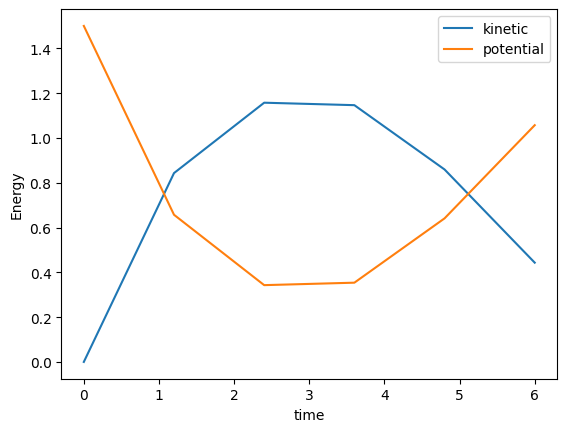

In [45]:

for t in time_steps:

    results = exponentiation(prob,max_depth,H_final,t)

    data = parse_results(results,basis_states, N)
    probs = data['prob']

    print(len(probs))

    KE_0.append(E_0*probs[1])
    KE_1.append(E_0*probs[2])
    KE_2.append(E_0*probs[3])
    KE_3.append(E_0*probs[4])

    kin = kinectic_part(probs).sum()*E_0
    pontential = potential_part(probs).sum()*E_0

    total_kinetic.append(kin)
    total_potential.append(pontential)

    
#plotting
plt.plot(time_steps, total_kinetic, label='kinetic')
plt.plot(time_steps, total_potential, label='potential')  

plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
KE_sub=[]
PE_sub=[]


Note: The plot is a little bit different from the one in the video because we found a bug on the code after the recording. Fixing that bug the plot also changed.

$\langle KE(t) \rangle$ and potential energy $\langle PE(t) \rangle$ of the entire system


In [46]:
AvgKE = sum(total_kinetic)/len(total_kinetic)

AvgPE = sum(total_potential)/len(total_potential)

check_2


Verifying the energy of entire system after evolution is equal to the energy of before evolution


In [47]:
is_Energy_constant(total_kinetic[-1],total_potential[-1],E_0)
is_Energy_constant(AvgKE,AvgPE,E_0)

True

$\langle KE(t) \rangle$ and potential energy $\langle PE(t) \rangle$ of the sub-system of k oscillators between k=0 and l+k=3.


In [48]:
for t in range(0,len(KE_0)):
    KE_sub.append(KE_0[t] + KE_1[t] + KE_2[t] + KE_3[t])
    

AvgKE_sub = sum(KE_sub)/len(KE_0)
AvgPE_sub = E_0 - AvgKE_sub

Check 2:

we ran the above simulation iteratively over evolution_coefficient in range (0,t) for N=2, and storing and graphing the velocity of an individual osscilator against t.


#### Tracking Velocities/KE of 2-identical oscillators


Text(0, 0.5, 'Kinetic Energy')

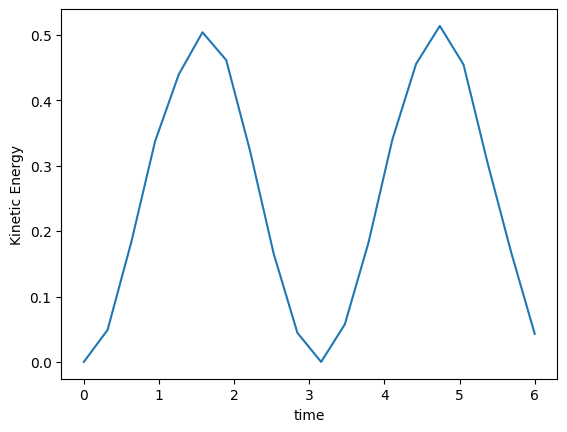

In [50]:

#defining system    
N_t = 2
k_t = 1
m_t = 1
x_t = [1,1]
v_t = [0,0]
basis_states_t = set(basis(2))

#time parameters

t_f = 6
num_points_t = 20
time_steps = np.linspace(0, t_f, num = num_points_t)
basis_states = set(basis(n))
#Building essential matrices

K_t = get_k_1D_identical(N_t,k_t)
M_t = get_mass_identical(N_t,m_t)
F_t = get_Force(K_t)
(H_t,B_t) = get_H_B(F_t,M_t)
(psi_t,prob_t,norm_t) = get_normalized_psi(B_t,M_t,x_t,v_t)
E_0 = (norm_t**2)/2.0

#reformating the Hamiltion

H_pauli_t = lcu_naive(H_t)
H_final_t = pauli_operator_to_hamiltonian(H_pauli_t)


KE_particle_0 = []
PE_particle_0 = []

for t in time_steps:
    results_t = exponentiation(prob_t,40000,H_final_t,t)

    data = parse_results(results_t,basis_states_t, N_t)

    probs_t = data['prob']

    kin = kinectic_part(probs_t) * E_0
    pontential = potential_part(probs_t)* E_0

    KE_particle_0.append(kin[0])
    PE_particle_0.append(pontential[0])
        
        
        
#plotting

plt.plot(time_steps, KE_particle_0, label='kinetic energy of 0th particle')
plt.xlabel('time')
plt.ylabel('Kinetic Energy')

#### Simulation for large system (N = 128)


In [56]:
n = 7
N = 2**n
m = 1
k = 1

#changing x_zero and x_dot_zero change the no of qbits utlised

x_zero = [0]*N
x_dot_zero = [0]*N

for i in range(0,N//2):
    x_zero[i] = 1

#changing t changes the depth of the system

t = 10

max_depth = 29000

K = get_k_1D_identical(N,k)
M = get_mass_identical(N,m)

basis_states = set(basis(n+1))


F = get_Force(K)
(H,B) = get_H_B(F,M)
(psi,prob,norm) = get_normalized_psi(B,M,x_zero,x_dot_zero)
E_0 = (norm**2)/2.0

H_pauli = lcu_naive(H)
H_final = pauli_operator_to_hamiltonian(H_pauli)

results = exponentiation(prob,max_depth,H_final,t, write_qmodel_file=True, write_qprog_file=True,show_qrog = False)

data = parse_results(results_t,basis_states_t, N_t)

probs = data['prob']





Note

Above are the implimentations for N=8, N=128 but given the parmetric nature of the algorithm we can run a system with larger or smaller number of qbits by simply changing n and increse or decrease depth by changing max_depth of our Quantum circuit.


#### Simulation of non-identical oscillators


we propose a function that is designed to simulate the systems with higher dimensionality, extending beyond the requirement for a linear oscillator arrangement


This takes input a diagonal Matrix of masses and a matrix containing spring constants both of which should be of size :$ N \times N $ formed in accordance to description in Babush et al.


In [52]:
def Non_identical_oscillators(max_depth,t,n,K,M,x_zero,x_dot_zero,qbits_used):
    N=2**n
    
    F=get_Force(K)
    (H,B) = get_H_B(F,M)
    (psi,prob,norm)=get_normalized_psi(B,M,x_zero,x_dot_zero)
    E_0 = (norm**2)/2.0

    basis_states = set(basis(qbits_used))
    H_pauli = lcu_naive(H)
    H_final = pauli_operator_to_hamiltonian(H_pauli)

    results = exponentiation(prob,max_depth,H_final,t,write_qmodel_file = True)

    data = parse_results(results,basis_states, N)

    probs = data['prob']

    total_kinetic = kinectic_part(probs).sum()
    total_potential = potential_part(probs).sum()

    return(total_kinetic, total_potential)    

Note

If values in the prob are truncated then they don't sum to 1.

The knownledge of the number of qbits needed to do `state_preparation` is required and must be given as an argument `qbits_used` to this function
